<a href="https://colab.research.google.com/github/taimur1871/inventory_boosted_trees/blob/main/Rana_hyper_parameter_optimization_ML_Walmart_Labs_Inventory.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Hyperparameter Tuning

In [ ]:
## Importing required Libraries
import os
import numpy as np
import pandas as pd
import seaborn as sns

### Read in the training data

In [ ]:
X_train = pd.read_csv("X_train.csv")

### Convert the non-numeric features to numeric

In [ ]:
X_train['weekday'] = X_train['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
X_train['timeOfDay'] = X_train['timeOfDay'].replace(['Dawn','EarlyMorning','Morning',
                                                     'Noon','Afternoon','Evening','Night'],[1,2,3,4,5,6,7])

## Test data

In [ ]:
X_test = pd.read_csv("X_test.csv")
print(X_test.shape)
X_test['weekday'] = X_test['weekday'].replace(['Mon','Tue','Wed','Thu','Fr','Sat','Sun'],[1,2,3,4,5,6,7])
X_test['timeOfDay'] = X_test['timeOfDay'].replace(['Dawn','EarlyMorning','Morning','Noon',
                                                   'Afternoon','Evening','Night'],[1,2,3,4,5,6,7])

(430544, 15)


In [ ]:
# Extract the 'Purchase' columns of the datasets as your targets
y_train = X_train.iloc[:,-1]
y_test  = X_test.iloc[:,-1]
# You can change the wording of the print() commands from "Percentage" to "Fraction" if you prefer
print(f'Percentage of purchases in training = {(np.sum(y_train)*100)/len(y_train)}') 
print(f'Percentage of purchases in test = {(np.sum(y_test)*100)/len(y_test)}')

Percentage of purchases in training = 1.3900244032355966
Percentage of purchases in test = 1.421457504924003


# Find & Vizualize the Optimal Set of Features for this data set.
    

In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns
print(f'The training data currently has {X_train.shape[1]} features')

The training data currently has 15 features


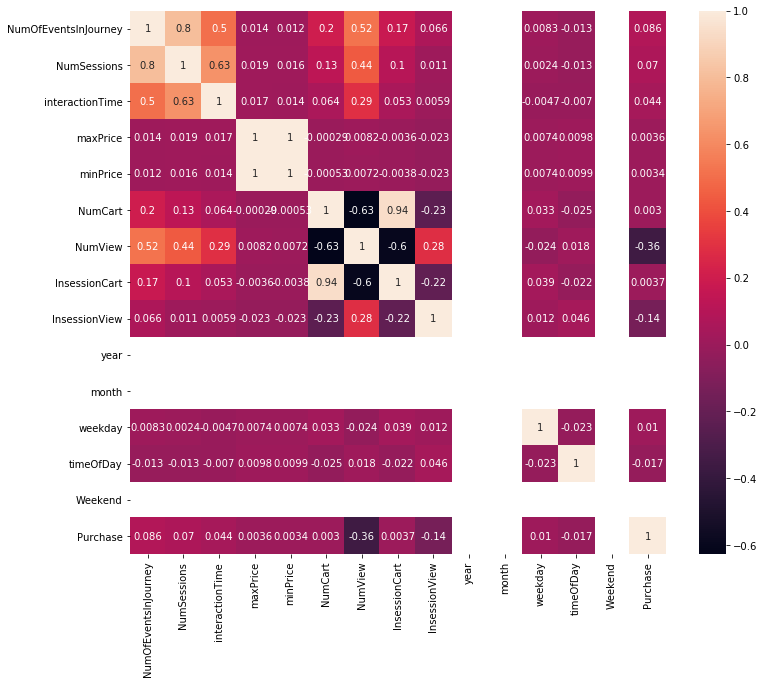

In [ ]:
#Visual inspection of features
plt.figure(figsize=(12,10))

# Compute the Pearson Correlation of each feature in the training df
cor = X_train.corr()

# Plot the correlations
sns.heatmap(cor, annot=True)
plt.show()

In [ ]:
# replace the NAN values with 1
cor = cor.fillna(1)

### Drop features with high correlations

In [ ]:
# Initialize a list indicating whether to keep a column in the training df
keep_columns = np.full((cor.shape[0],), True, dtype=bool)
# Loop over all columns
for i in range(cor.shape[0]-1):
    # Loop over all columns to the right of the current one
    for j in range(i+1, cor.shape[0]-1):
        # If the absolute correlation between the current two columns is greater than or equal to 0.8, or no correlation 0 value...
        if (np.abs(cor.iloc[i,j]) >= 0.8):
            # If we haven't already told the keep_columns list to drop column j...
            if keep_columns[j]:
                # Drop column j
                keep_columns[j] = False
# Extract the columns to keep from the training df
selected_columns = X_train.columns[keep_columns]
# Make a new df with the columns we've decided to keep from the training df
X_out = X_train[selected_columns]

print('The following columns are present in the new data:')
print(selected_columns)
print(f'The old data had {X_train.shape[1]} features. The new df has {X_out.shape[1]} features.')
print(y_train.shape)
X_out.head()

The following columns are present in the new data:
Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')
The old data had 15 features. The new df has 7 features.
(645816,)


,NumOfEventsInJourney,interactionTime,maxPrice,NumCart,NumView,InsessionView,Purchase
0,1,0.0,154.41,0,1,1,0
1,1,0.0,92.67,0,1,1,0
2,1,0.0,155.71,0,1,1,0
3,1,0.0,898.32,0,1,1,0
4,1,0.0,146.21,0,1,1,0


### Feature Selection on p-value (statistical significance to Y value)

In [ ]:
selected_columns = selected_columns[0:]
import statsmodels.api as sm
def backwardElimination(x, y, sl, columns):
    numVars = len(x[0])
    for i in range(0, numVars):
        regressor_OLS = sm.OLS(y, x).fit()
        #maxVar = max(regressor_OLS.pvalues).astype(float)
        maxVar = max(regressor_OLS.pvalues)
        if maxVar > sl:
            for j in range(0, numVars - i):
                if (regressor_OLS.pvalues[j].astype(float) == maxVar):
                    x = np.delete(x, j, 1)
                    columns = np.delete(columns, j)
                    
    regressor_OLS.summary()
    return x, columns
SL = 0.01
# Note that we're passing in df_out, not df_train
data_modeled, selected_columns = backwardElimination(X_out.values, y_train, SL, selected_columns)

In [ ]:
print('The following columns remain based on p-value selection:')
print(selected_columns)
# Make a reduced df
data_red = pd.DataFrame(data = data_modeled, columns = selected_columns)
print(f'After selection by Pearson Correlation, we had {X_out.shape[1]} features.')
print(f'After selection by p-value, we have {data_red.shape[1]} features.')

The following columns remain based on p-value selection:
Index(['NumOfEventsInJourney', 'interactionTime', 'maxPrice', 'NumCart',
       'NumView', 'InsessionView', 'Purchase'],
      dtype='object')
After selection by Pearson Correlation, we had 7 features.
After selection by p-value, we have 7 features.


### Visualize the selected features

Ignore the warning messages about distplot. I should replace it with displot, but I haven't figured out how to overlay plots with it.

In [ ]:
fig = plt.figure(figsize = (20, 25))
j = 0
for i in data_red.columns:
    plt.subplot(3, 4, j+1)
    j += 1
    sns.distplot(data_red[i][data_red['Purchase']==0], color='g', label = 'no')
    sns.distplot(data_red[i][data_red['Purchase']==1], color='r', label = 'yes')
    plt.legend(loc='best')
fig.suptitle('Subscription Feature Analysis')
fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.show()

In [ ]:
from sklearn.preprocessing import normalize

X_train_np = data_red.drop(columns='Purchase')
X_train_np = normalize(X_train_np, axis=0, norm='max')
y_train_np = y_train.values

In [ ]:
X_test_np = pd.DataFrame(data = X_test, columns = selected_columns).drop(columns='Purchase')
X_test_np = normalize(X_test_np, axis=0, norm='max')
y_test_np = y_test.values

print(X_train_np.shape)
print(X_test_np.shape)

(645816, 6)
(430544, 6)


Feature ranking:
1. feature 3 (0.501193)
2. feature 4 (0.367738)
3. feature 5 (0.093052)
4. feature 0 (0.028238)
5. feature 1 (0.007418)
6. feature 2 (0.002363)


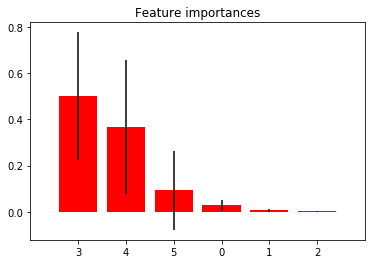

In [ ]:
#Use Random Forest to get feature ranks/importances for each feature
from sklearn.datasets import make_classification
from sklearn.ensemble import ExtraTreesClassifier

# Build a forest and compute the impurity-based feature importances
forest = ExtraTreesClassifier(n_estimators=20,
                              random_state=0)

forest.fit(X_train_np, y_train_np)
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train_np.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the impurity-based feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X_train_np.shape[1]), importances[indices],
        color="r", yerr=std[indices], align="center")
plt.xticks(range(X_train_np.shape[1]), indices)
plt.xlim([-1, X_train_np.shape[1]])
plt.show()

## Thus features 3 and 4 (numcart, numview) are the top two rated features that can be used to visualize. Let's set up a convenience function for this purpose.

Note that `X`, `y`, and `yhat` must be NumPy arrays for this function to work

In [ ]:
# This function visualizes the classification output on scatter plot
# Feature 1 (Interaction Time is used to observe the impact of low ranked feature)
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
def visualize_scatter_plot(X, y, yhat, title):
    loc11=np.where((y>0) & (yhat>0),1,0) #TP
    loc00=np.where((y==0) & (yhat==0),1,0) #TN
    loc10=np.where((y>0) & (yhat==0),1,0) #FN
    loc01=np.where((y==0) & (yhat>0),1,0) #FP
    fig = plt.figure(figsize = (10, 7))
    ax = plt.axes(projection ="3d")
    ax.scatter3D(X[np.where(loc00>0),3],X[np.where(loc00>0),4],X[np.where(loc00>0),1],color='blue', marker='o')
    ax.scatter3D(X[np.where(loc10>0),3],X[np.where(loc10>0),4],X[np.where(loc10>0),1],color='cyan', marker='o')
    ax.scatter3D(X[np.where(loc11>0),3],X[np.where(loc11>0),4],X[np.where(loc11>0),1],color='red', marker='^')
    ax.scatter3D(X[np.where(loc01>0),3],X[np.where(loc01>0),4],X[np.where(loc01>0),1],color='green', marker='^')
    ax.set_xlabel('NumCart')
    ax.set_ylabel('NumViews')
    ax.set_zlabel('InteractionTime')
    plt.title(title)
    plt.show()

# Hyperparameter Optimization
### Import models, metrics, and convenience functions

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import recall_score as recall
from sklearn.metrics import precision_score as precision
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_validate, cross_val_predict
from sklearn.neural_network import MLPClassifier

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
from sklearn.pipeline import make_pipeline

## Selecting Models to Optimize

Based on the data below the best models to optimize for Recall are NN and Balanced RF. We will focus on these methods for this exercise

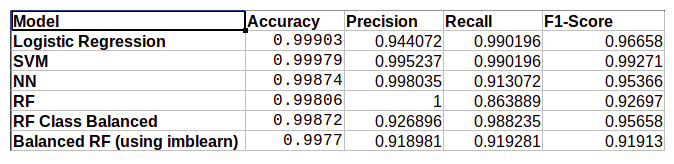

## Neural Network

Performing crossvalidation separately because it will be faster instead of using cross validation built in grid search sklearn implmentation

In [ ]:
nn_param_grid = [
  {'solver': ['sgd', 'adam']},
 ]

In [ ]:
cv_nn = cross_validate(MLPClassifier(), X_train_np, y_train_np, cv=5, return_estimator=True)
cv_nn['test_score']

array([1., 1., 1., 1., 1.])

### Evaluate the model

In [ ]:
# We are going to test over all the models and see if the scores vary considerably
# if we get a low recall we will perform a grid search to see if it works
for i in range(len(cv_nn['estimator'])):
    nn_model = cv_nn['estimator'][i]
    nn_pred = nn_model.predict(X_test_np)
    print('Test scores for model ', i)
    print('accuracy\t', accuracy(y_test_np, nn_pred))
    print('recall\t', recall(y_test_np, nn_pred))
    print('precision\t', precision(y_test_np, nn_pred))
    print('f1 score\t', f1_score(y_test_np, nn_pred), '\n')

Test scores for model  0
accuracy	 0.9987388048608272
recall	 0.9166666666666666
precision	 0.9941520467836257
f1 score	 0.9538383065544503 

Test scores for model  1
accuracy	 0.9987550633617005
recall	 0.915359477124183
precision	 0.996797153024911
f1 score	 0.9543441226575808 

Test scores for model  2
accuracy	 0.9987295142888997
recall	 0.9124183006535947
precision	 0.9980339588918677
f1 score	 0.953307725138711 

Test scores for model  3
accuracy	 0.998696997287153
recall	 0.9099673202614379
precision	 0.9982075640795841
f1 score	 0.952047183519959 

Test scores for model  4
accuracy	 0.9987968709353748
recall	 0.9178104575163398
precision	 0.9973366477272727
f1 score	 0.9559223961878829 



### The above tests show that recall has not improved significantly. We will use the model 0 to do a grid search

In [ ]:
# Instantiate, train, and predict with the model
grid_nn = GridSearchCV(cv_nn['estimator'][0], nn_param_grid)
grid_nn.fit(X_train_np, y_train_np)

grid_nn.best_params_

{'solver': 'adam'}

In [ ]:
nn_pred = grid_nn.predict(X_test_np)

Accuracy = 0.9987527407187187, Precision = 0.9978598180845372, Recall = 0.9142156862745098, F1-score = 0.9542082374008697
Confusion Matrix is:
[[424412     12]
 [   525   5595]]


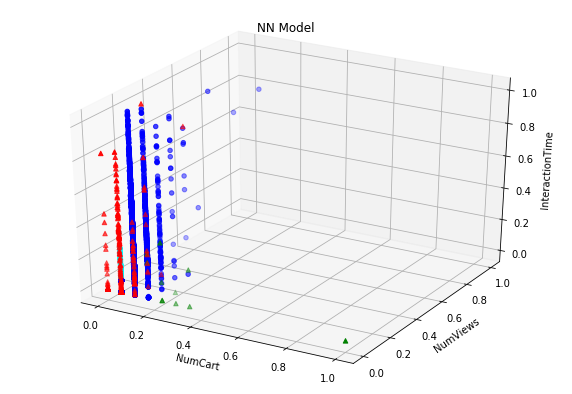

In [ ]:
# calculate the scores and evaluate various matrix
cmnn_nn = confusion_matrix(y_test_np, nn_pred)
acc_nn  = accuracy(y_test_np, nn_pred)
rec_nn  = recall(y_test_np, nn_pred)
prec_nn = precision(y_test_np, nn_pred)
f1_nn   = f1_score(y_test_np, nn_pred)

# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc_nn}, Precision = {prec_nn}, Recall = {rec_nn}, F1-score = {f1_nn}')
print('Confusion Matrix is:')
print(cmnn_nn)
visualize_scatter_plot(X_test_np,y_test_np,nn_pred,'NN Model')

Despite using adam optimizer the recall does not improve. There are other hyperparameters that can be tested but these are slow and it does not seem like a good choice to spend recources on this particular model.

## Random Forest - Gradient Boosted Trees

In [ ]:
from imblearn.ensemble import BalancedRandomForestClassifier

In [ ]:
brf_param_grid = [
  {'n_estimators': [10, 100, 1000]},
 ]

In [ ]:
# Instantiate, train, and predict with the classifier using crossvalidation
cv_brf = cross_validate(BalancedRandomForestClassifier(max_depth=5, random_state=0), X_train_np,
                         y_train_np, cv=5, return_estimator=True)
cv_brf['test_score']

array([0.99317147, 0.99321013, 0.9930398 , 0.99304754, 0.9927456 ])

In [ ]:
# We are going to test over all the models and see if the scores vary considerably
# if we get a low recall we will perform a grid search to see if it works
for i in range(len(cv_brf['estimator'])):
    brf_model = cv_brf['estimator'][i]
    brf_pred = brf_model.predict(X_test_np)
    print('Test scores for model ', i)
    print('accuracy\t', accuracy(y_test_np, brf_pred))
    print('recall\t', recall(y_test_np, brf_pred))
    print('precision\t', precision(y_test_np, brf_pred))
    print('f1 score\t', f1_score(y_test_np, brf_pred), '\n')

Test scores for model  0
accuracy	 0.9974985135084916
recall	 0.9052287581699346
precision	 0.9176743415603776
f1 score	 0.911409064736366 

Test scores for model  1
accuracy	 0.9986877067152254
recall	 0.9826797385620915
precision	 0.9290900664297853
f1 score	 0.9551338044945605 

Test scores for model  2
accuracy	 0.9979421383180349
recall	 0.9245098039215687
precision	 0.9302860901019402
f1 score	 0.9273889526307163 

Test scores for model  3
accuracy	 0.9975194172953287
recall	 0.9008169934640523
precision	 0.9228322731837965
f1 score	 0.911691747974202 

Test scores for model  4
accuracy	 0.9975612248690029
recall	 0.9037581699346405
precision	 0.923064085447263
f1 score	 0.9133091149273448 



### One of the models actually has very high recall, we will use model 1 to perform grid search

In [ ]:
# perform grid search on the best model
grid_brf = GridSearchCV(cv_brf['estimator'][1], brf_param_grid)
grid_brf.fit(X_train_np, y_train_np)

grid_brf.best_params_

{'n_estimators': 1000}

In [ ]:
# Instantiate, train, and predict with the classifier
predictionBR = grid_brf.predict(X_test_np)

Accuracy = 0.9985878330670036, Precision = 0.923478795328826, Recall = 0.9820261437908496, F1-score = 0.9518530250237568
Confusion Matrix is:
[[423926    498]
 [   110   6010]]


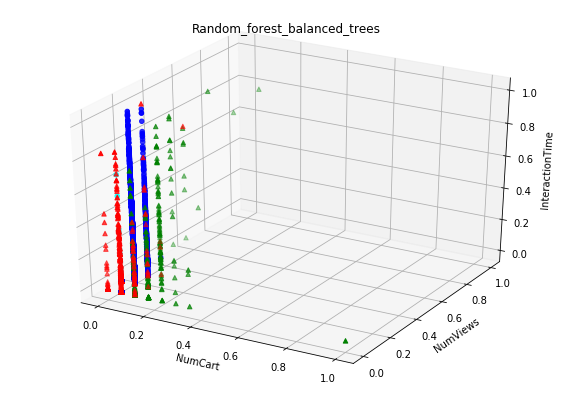

In [ ]:
# Compute the confusion matrix and evaluation metrics
cm_brf   = confusion_matrix(y_test_np, predictionBR)
acc_brf  = accuracy(y_test_np, predictionBR)
rec_brf  = recall(y_test_np, predictionBR)
prec_brf = precision(y_test_np, predictionBR)
f1_brf   = f1_score(y_test_np, predictionBR)
### END CODE HERE ###
# Print the metrics, display the confusion matrix, and visualize the model
print(f'Accuracy = {acc_brf}, Precision = {prec_brf}, Recall = {rec_brf}, F1-score = {f1_brf}')
print('Confusion Matrix is:')
print(cm_brf)
visualize_scatter_plot(X_test_np, y_test_np, predictionBR, 'Random_forest_balanced_trees')

In [ ]:
cols = np.array((selected_columns[:-1])).astype(str)
print(cols)

['NumOfEventsInJourney' 'interactionTime' 'maxPrice' 'NumCart' 'NumView'
 'InsessionView']


In [ ]:
print(grid_brf.best_estimator_)

BalancedRandomForestClassifier(max_depth=5, n_estimators=1000, random_state=0)


### Visualize the decision tree

In [ ]:
from sklearn.tree import export_graphviz

In [ ]:
# Export as dot file
export_graphviz(grid_brf.best_estimator_[0], max_depth=5, out_file='optimized_tree_brf.dot', 
                feature_names = cols,
                rounded = True, proportion = False, 
                precision = 2, filled = True)

# Convert to png using system command (requires Graphviz)
from subprocess import call
call(['dot', '-Tpng', 'optimized_tree_brf.dot', '-o', 'optimized_tree_brf.png', '-Gdpi=600'])

# Display in jupyter notebook
from IPython.display import Image
Image(filename = 'optimized_tree_brf.png')

# Effects of Hyperparameter Tuning

The model improves significantly using a higher number of trees. However, it does not significantly improve precision in this case. Comparing to the model original model with 100 trees the overall performance is not much different. The second nodes still minimize the gini for NumVIew and InteractionTime. The next factor in NumView is the price. Similarly in the next level from InteractionTime the most important factor is NumCart followed by maxPrice. It seems like that optimizing for more time on the website and then prioritizing based on the relative prices can improve user purchase decision and also give us a better idea of which items to keep in high numbers.